<a href="https://colab.research.google.com/github/Blackwidow2981/frauddetection/blob/main/AI_SyberthonFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bank Fraud Detection-EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import plotly.graph_objects as go
import imblearn

from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv("/content/drive/MyDrive/AI Syberthon/Syberthon/Dataset.csv")

Mounted at /content/drive


In [ ]:
df.drop('isFlaggedFraud',axis=1,inplace=True)

In [ ]:
df.head

<bound method NDFrame.head of          step      type     amount  ... oldbalanceDest  newbalanceDest  isFraud
0           1   PAYMENT    9839.64  ...           0.00            0.00        0
1           1   PAYMENT    1864.28  ...           0.00            0.00        0
2           1  TRANSFER     181.00  ...           0.00            0.00        1
3           1  CASH_OUT     181.00  ...       21182.00            0.00        1
4           1   PAYMENT   11668.14  ...           0.00            0.00        0
...       ...       ...        ...  ...            ...             ...      ...
1048570    95  CASH_OUT  132557.35  ...      484329.37       616886.72        0
1048571    95   PAYMENT    9917.36  ...           0.00            0.00        0
1048572    95   PAYMENT   14140.05  ...           0.00            0.00        0
1048573    95   PAYMENT   10020.05  ...           0.00            0.00        0
1048574    95   PAYMENT   11450.03  ...           0.00            0.00        0

[1048575 

In [ ]:
df['step']

0           1
1           1
2           1
3           1
4           1
           ..
1048570    95
1048571    95
1048572    95
1048573    95
1048574    95
Name: step, Length: 1048575, dtype: int64

**Correlation graph**

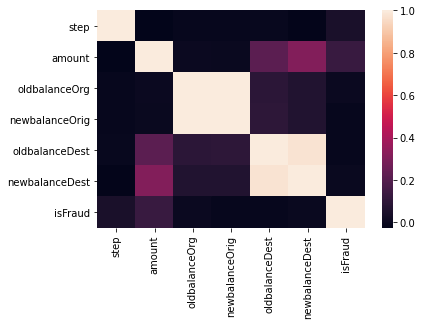

In [ ]:
sns.heatmap(df.corr())

**Dispersion Over Amount **

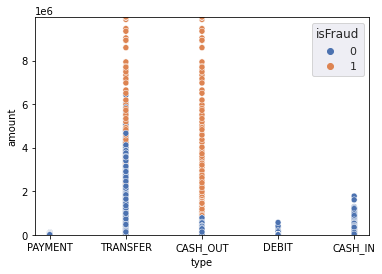

In [ ]:
ymin,ymax=plt.ylim()
scale_factor=9977762
plt. ylim(ymin * scale_factor, ymax * scale_factor)
sns.set(rc={'figure.figsize': (10,10)})
sns.scatterplot(data=df,x=df['type'],y=df['amount'],hue=df['isFraud'])

**Number of fraud and genuine transactions w.r.t to type of Transaction**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



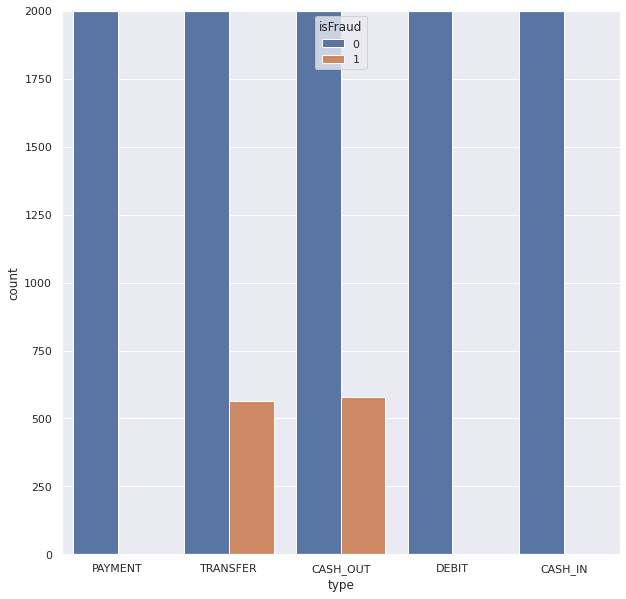

In [ ]:
ymin,ymax=plt.ylim()
scale_factor=2000
plt. ylim(ymin * scale_factor, ymax * scale_factor)
sns.countplot(df.type, hue=df['isFraud'])  
plt.show()  

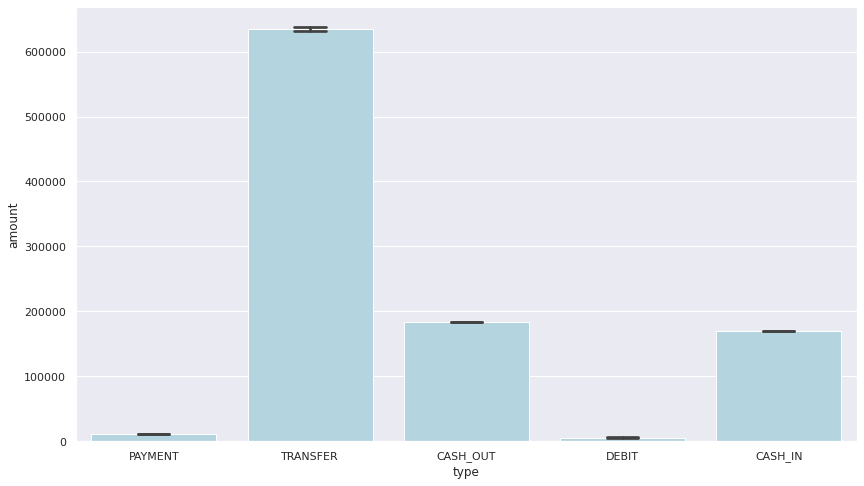

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x="type", y="amount", data=df, estimator=np.mean, ci=85, capsize=.2, color='lightblue')

In [57]:
class_0 = df.loc[df['isFraud'] == 0]["step"]
class_1 = df.loc[df['isFraud'] == 1]["step"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title=' Time Density Plot', xaxis=dict(title='Time [s]'),yaxis=dict(title='Density'))
iplot(fig, filename='dist_only')

In [ ]:
df_copy=df.loc[(df.type=='TRANSFER') | (df.type=='CASH_OUT')]
df_copy=df_copy.assign(errorbalanceDest=df_copy['oldbalanceDest']+df_copy['amount']-df_copy['newbalanceDest'])
df_copy=df_copy.assign(errorbalanceOrig=df_copy['newbalanceOrig']+df_copy['amount']-df_copy['oldbalanceOrg'])
df_copy

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,errorbalanceDest,errorbalanceOrig
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,1.810000e+02,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,2.136300e+04,0.00
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,1.827035e+05,213808.94
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,2.377353e+05,214605.30
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,-2.401220e+06,300850.89
...,...,...,...,...,...,...,...,...,...,...,...,...
1048553,95,CASH_OUT,103391.93,C2021893664,107623.00,4231.07,C178178755,5752648.68,5856040.61,0,-9.313226e-10,0.00
1048558,95,CASH_OUT,26535.41,C1213094114,104187.00,77651.59,C216374600,205460.26,231995.66,0,1.000000e-02,0.00
1048565,95,TRANSFER,132387.24,C1654402840,15956.51,0.00,C1878219072,631284.08,763671.32,0,0.000000e+00,116430.73
1048567,95,CASH_OUT,279674.05,C990252469,18002.85,0.00,C574439165,1847488.28,2127162.32,0,1.000000e-02,261671.20


In [ ]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
Y = X['isFraud']
del X['isFraud']
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)


In [ ]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.5, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



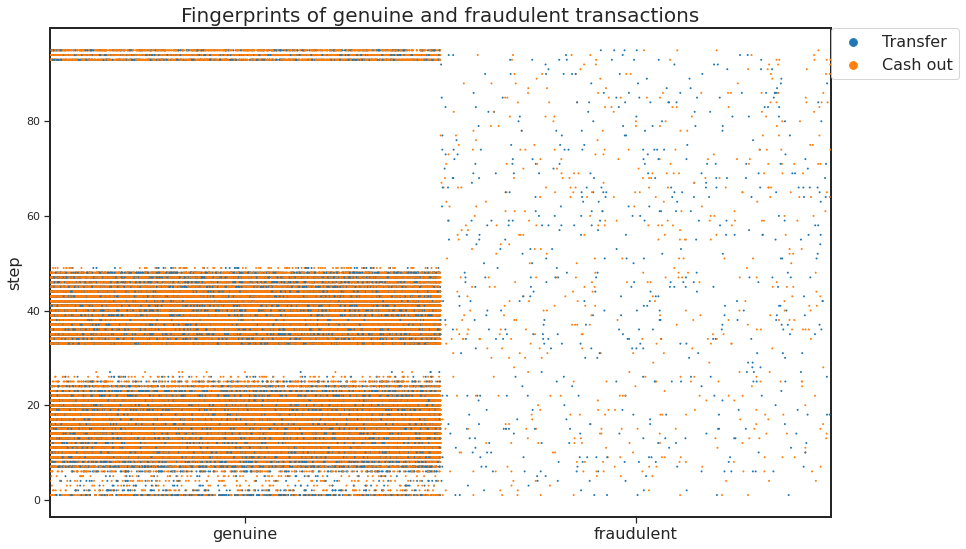

In [ ]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('step', size = 16)
ax.set_title('Fingerprints of genuine and fraudulent transactions', size = 20);

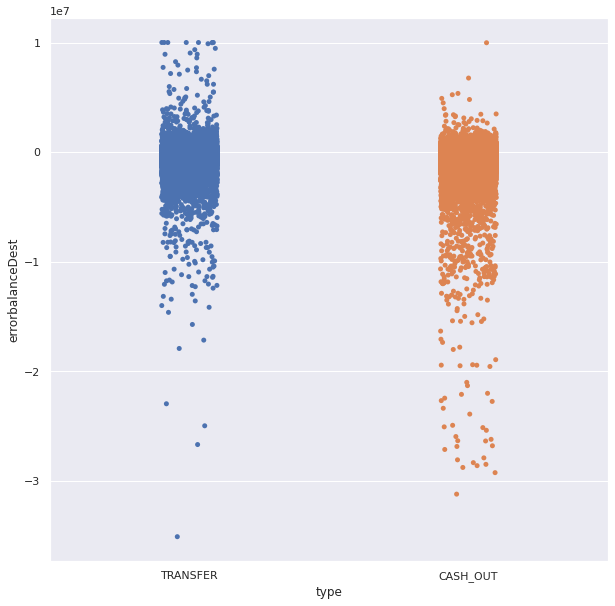

In [ ]:
sns.stripplot(x="type", y="errorbalanceDest", data=df_copy)

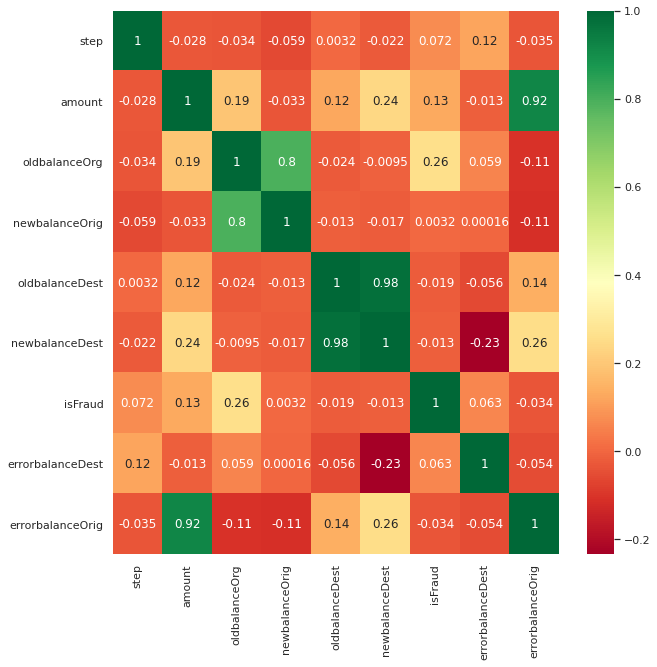

In [ ]:
corrmat = df_copy.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df_copy[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
df_copy=pd.concat([df_copy,pd.get_dummies(df_copy['type'], prefix='type_')],axis=1)
df_copy.drop(['type'],axis=1,inplace = True)

In [ ]:
X=df_copy.copy().drop(['isFraud','nameDest','nameOrig'],axis=1)
y=df_copy['isFraud']
y.shape

(460394,)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X, y = sm.fit_resample(X, y)
  
print('After OverSampling, the shape of train_X: {}'.format(X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y == 0)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



After OverSampling, the shape of train_X: (918504, 10)
After OverSampling, the shape of train_y: (918504,) 

After OverSampling, counts of label '1': 459252
After OverSampling, counts of label '0': 459252


In [ ]:
#Splitting the dataset in the train:test ratio of 80:20.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Naive Bayes Classification**

In [ ]:
model=GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.685488919494178


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.97      0.76     91874
           1       0.94      0.40      0.56     91827

    accuracy                           0.69    183701
   macro avg       0.78      0.69      0.66    183701
weighted avg       0.78      0.69      0.66    183701



In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))

[[89371  2503]
 [55273 36554]]


**Random forest classification**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)


In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))

[[89371  2503]
 [55273 36554]]


In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9998203602593345


In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))

[[91855    19]
 [   14 91813]]


**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree

|--- feature_1 <= 4823882.75
|   |--- feature_0 <= 49.50
|   |   |--- feature_5 <= 6.05
|   |   |   |--- feature_8 <= 0.50
|   |   |   |   |--- feature_4 <= 44.50
|   |   |   |   |   |--- feature_7 <= 589.46
|   |   |   |   |   |   |--- feature_3 <= 5790.79
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_3 >  5790.79
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_7 >  589.46
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_4 >  44.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_8 >  0.50
|   |   |   |   |--- feature_0 <= 6.50
|   |   |   |   |   |--- feature_7 <= 1392.91
|   |   |   |   |   |   |--- feature_2 <= 97704.42
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_2 >  97704.42
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_7 >  1392.91
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  6.50
|   |   |   |   |   |-

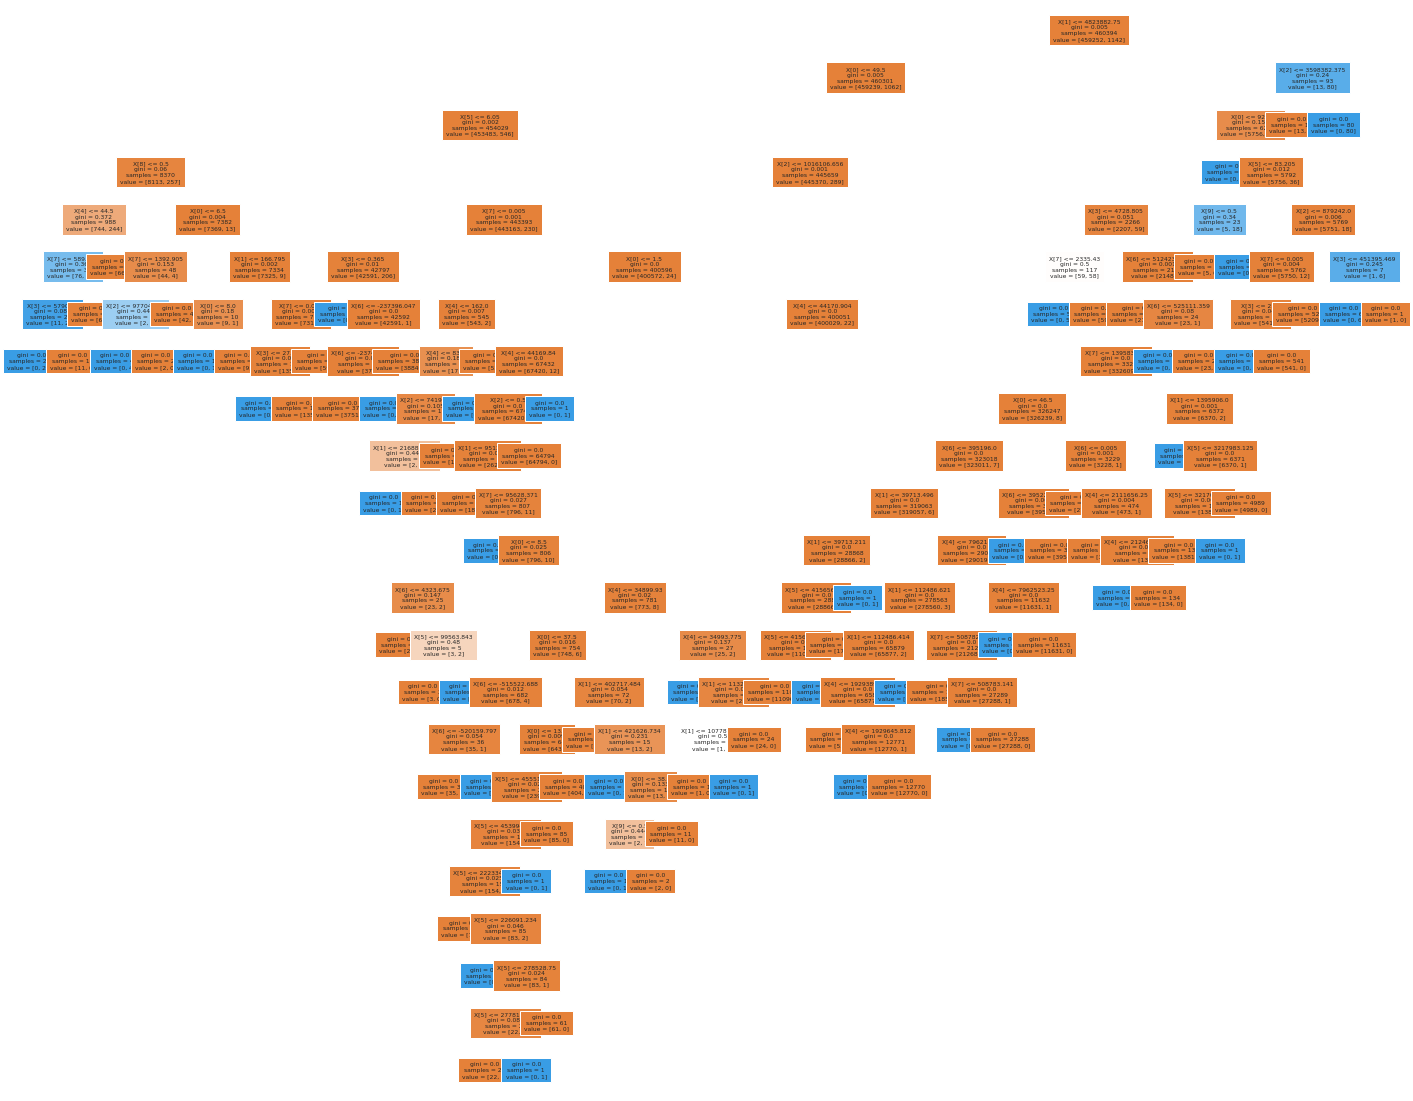

In [ ]:
X=df_copy.copy().drop(['isFraud','nameDest','nameOrig'],axis=1)
y=df_copy['isFraud']
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X, y)
text_representation = tree.export_text(clf)
print(text_representation)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=None,class_names=None,filled=True,fontsize=6)
fig.savefig("decision_tree.png")

In [ ]:
from sklearn import metrics

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91874
           1       1.00      1.00      1.00     91827

    accuracy                           1.00    183701
   macro avg       1.00      1.00      1.00    183701
weighted avg       1.00      1.00      1.00    183701

0.9998258038878395
[[91857    17]
 [   15 91812]]


**Logistic Regression** 

In [ ]:
model = LogisticRegression(solver='liblinear',random_state=42).fit(X, y)
y_pred=model.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))

[[91805    69]
 [23523 68304]]


In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8715739163096554


**XG Boost**

In [ ]:
X=df.copy().drop(['isFraud','nameDest','nameOrig','type'],axis=1)
X=X.assign(errorbalanceDest=X['oldbalanceDest']+X['amount']-X['newbalanceDest'])
X=X.assign(errorbalanceOrig=X['newbalanceOrig']+X['amount']-X['oldbalanceOrg'])
y=df['isFraud']
X.dtypes

step                  int64
amount              float64
oldbalanceOrg       float64
newbalanceOrig      float64
oldbalanceDest      float64
newbalanceDest      float64
errorbalanceDest    float64
errorbalanceOrig    float64
dtype: object

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
y_train.shape

(838860,)

In [ ]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))

[[89371  2503]
 [55273 36554]]
Accuracy: 0.685488919494178


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.97      0.76     91874
           1       0.94      0.40      0.56     91827

    accuracy                           0.69    183701
   macro avg       0.78      0.69      0.66    183701
weighted avg       0.78      0.69      0.66    183701



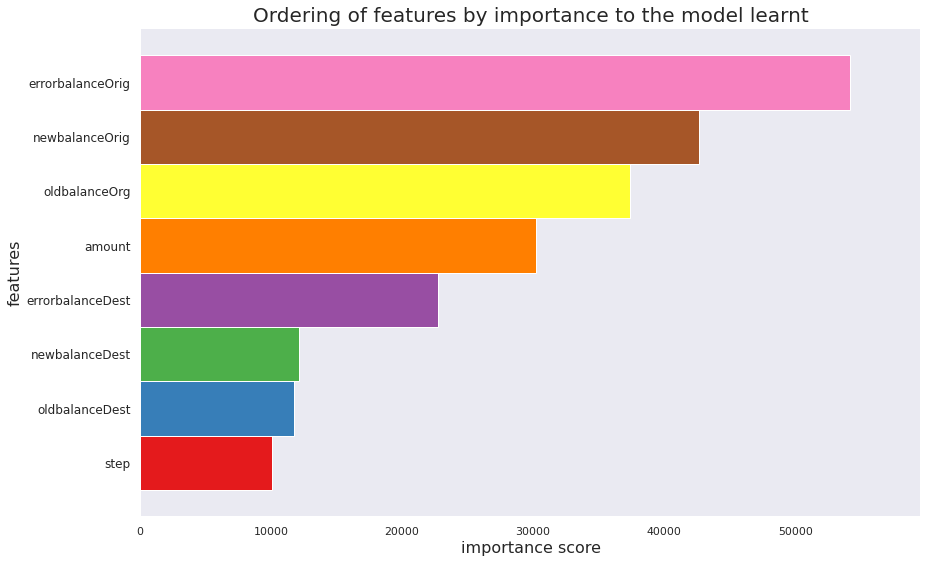

In [ ]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

### ***XG boost had the highest accuracy.***